In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Load datasets

In [2]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output/')
coords_main = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

In [3]:
# Budget terms
ds_budg = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_budgets/')
coords_budg = ds_budg.coords.to_dataset().reset_coords()
ds_budg = ds_budg.reset_coords(drop=True)

In [4]:
# Open dataset from file
ds = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH/')

In [5]:
d = 300

### Pick grid point
- `face (f)`
- `verical index (j)`
- `horizontal index (i)`

In [6]:
f = 8
j = 60
i = 45

lon = coords_main.XC[f,j,i].values
lat = coords_main.YC[f,j,i].values
print(r'Longitude: %.2f,' % lon,'Latitude: %.2f' % lat)

Longitude: -157.50, Latitude: -24.77


In [7]:
south = -30
north = -15
west = -180
east = -120

patch_lats = [south, north, north, south]
patch_lons = [west, west, east, east]

### Map

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


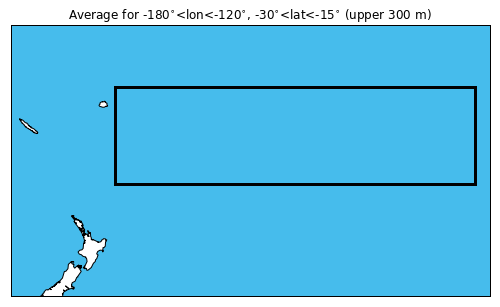

In [8]:
fig = plt.figure(figsize=(10,5))

#plt.title(r'Grid point at lon = %.2f and lat = %.2f (upper %.0f m)' % (lon,lat,d), fontsize=12)
#plt.title('%.0f-by-%.0f average centered at \n lon = %.2f and lat = %.2f (upper %.0f m)' % (2*dd+1,2*dd+1,lon,lat,d),
#          fontsize=12)
plt.title(r'Average for %.0f$^{\circ}$<lon<%.0f$^{\circ}$, %.0f$^{\circ}$<lat<%.0f$^{\circ}$ (upper %.0f m)' % (west,east,south,north,d),
          fontsize=12)
m = Basemap(llcrnrlon=lon-40,llcrnrlat=lat-20,urcrnrlon=lon+40,urcrnrlat=lat+20,
            lat_0=lat,lon_0=lon,projection='merc',resolution = 'l',area_thresh=10000.)
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')

# Grid point
#lons, lats = m(lon, lat)
#m.scatter(lons, lats, marker = 'o', s=15, color='k', zorder=5)

# Polygon
x, y = m(patch_lons, patch_lats)
xy = np.zeros(shape=(len(x),2))
xy[:,0] = x
xy[:,1] = y
patch = Polygon(xy, fc='None', ec='k', linewidth=3, linestyle='-')
plt.gca().add_patch(patch)

plt.savefig('/rigel/home/jt2796/figure.pdf')
plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

In [9]:
# Volume (m^3)
vol = (coords_main.rA*coords_main.drF*coords_main.hFacC).transpose('face','k','j','i')

### Subselect

In [10]:
vol = vol.where((coords_main.XC>=np.min(patch_lons))&(coords_main.XC<=np.max(patch_lons))&\
                (coords_main.YC>=np.min(patch_lats))&(coords_main.YC<=np.max(patch_lats)))

In [11]:
ds = ds.where((coords_main.XC>=np.min(patch_lons))&(coords_main.XC<=np.max(patch_lons))&\
              (coords_main.YC>=np.min(patch_lats))&(coords_main.YC<=np.max(patch_lats)))

### Add depth and volume to coordinates

In [12]:
ds.coords['Z'] = coords_main.Z
ds.coords['vol'] = vol

In [13]:
# For depth averaging
ds.coords['hFacC'] = coords_main.hFacC
ds.coords['drF'] = coords_main.drF

In [14]:
ds = ds.swap_dims({'k':'Z'})

### Define depth level of control volume

In [15]:
z_lower = 310
print('Deepest depth layer at',ds.sel(Z=slice(0,-z_lower)).Z[-1].values,' m')

Deepest depth layer at -299.93  m


### Depth-averaging

### Volume-weighted average

In [16]:
vol = ds.sel(Z=slice(0,-z_lower)).vol
ds_aveZ = (ds.sel(Z=slice(0,-z_lower))*vol).sum(dim=['face','Z','j','i'])/vol.sum(dim=['face','Z','j','i'])

### Load results

In [17]:
# Average
results = dask.compute(ds_aveZ.tnd,ds_aveZ.hadv_Uanom_Tclim,ds_aveZ.vadv_Uanom_Tclim,
                       ds_aveZ.hadv_Uclim_Tanom,ds_aveZ.vadv_Uclim_Tanom,
                       ds_aveZ.hdif+ds_aveZ.vdif,ds_aveZ.frc,
                       ds_aveZ.hadv_Uanom_Tanom+ds_aveZ.vadv_Uanom_Tanom,ds_aveZ.res)

In [18]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8]
adv = results[1] + results[2] + results[3] + results[4] + results[7]

### Dataframe of time series

In [19]:
df = pd.DataFrame({'tnd':results[0],
                   'hadv_Uanom_Tclim':results[1],'vadv_Uanom_Tclim':results[2],
                   'hadv_Uclim_Tanom':results[3],'vadv_Uclim_Tanom':results[4],
                   'dif':results[5],'frc':results[6],
                   'adv_Uanom_Tanom':results[7],'res':results[8],
                   'total':total,'adv':adv})

### Correlation

In [20]:
corr = pd.Series({term: df['tnd'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.tnd,ddof=1)

In [21]:
corr

hadv_Uanom_Tclim    1.250618
vadv_Uanom_Tclim   -0.722079
hadv_Uclim_Tanom    0.004908
vadv_Uclim_Tanom    0.001141
dif                 0.001513
frc                 0.462973
adv_Uanom_Tanom     0.000410
res                 0.000516
total               1.000000
adv                 0.534997
dtype: float64

In [22]:
corr[:8].sum()

0.9999999882095375

In [23]:
corr = pd.Series({term: df['total'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.total,ddof=1)

In [24]:
corr[:8].sum()

0.999999996193597

In [25]:
varstrngs = ['Tendency',
             r'$\nabla_h(\mathbf{u}^{\prime}\overline{\theta}^m)$',
             r'$\frac{\partial}{\partial z}(w^{\prime}\overline{\theta}^m)$',
             r'$\nabla_h(\overline{\mathbf{u}}^m\theta^{\prime})$',
             r'$\frac{\partial}{\partial z}(\overline{w}^m\theta^{\prime})$',
             r'$\nabla{\mathbf{F_{diff}}^{\prime}}$',
             r'$F_{forc}^{\prime}$',
             r'$\nabla({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$',
             'Residual',
             'Total','Advection','Diffusion','Forcing']

### Plot timeseries (tendencies)

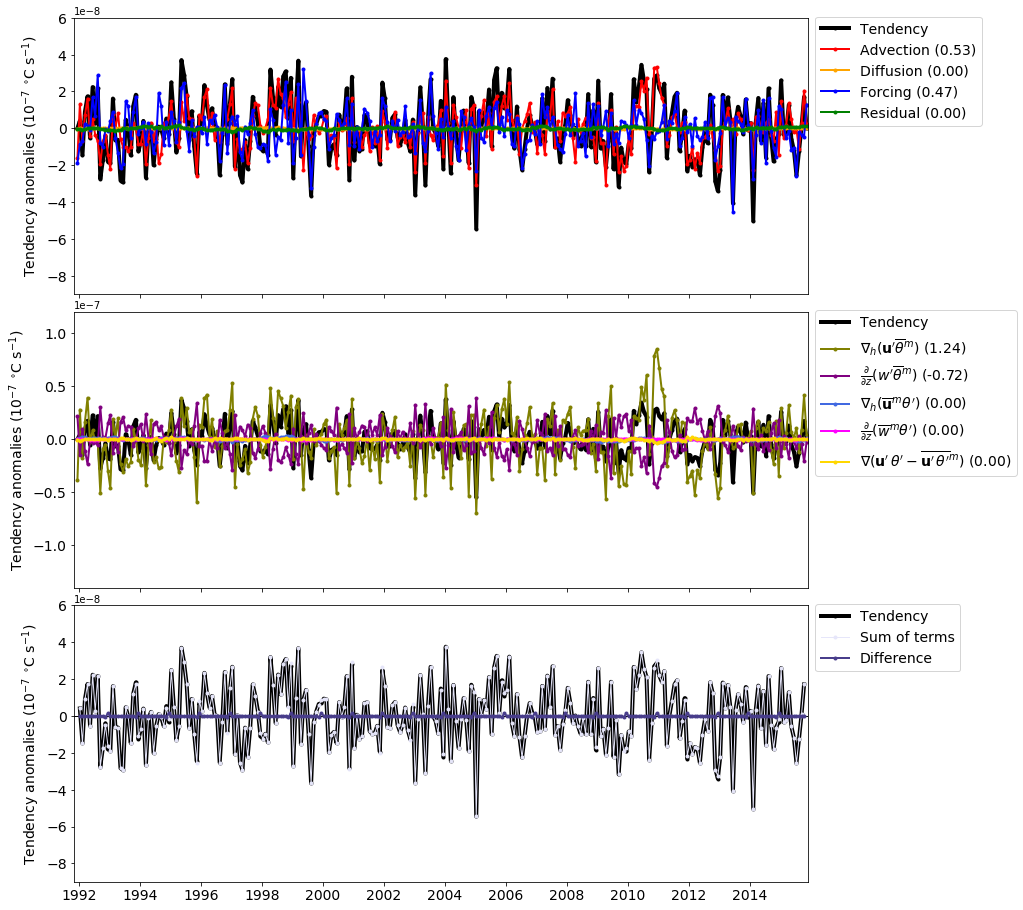

In [26]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(adv.time, adv, lw=2, color='red', marker='.',label=varstrngs[10] + ' (%.2f)' % corr[9])
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',label=varstrngs[11] + ' (%.2f)' % corr[4])
plt.plot(results[6].time, results[6], lw=2, color='blue', marker='.',label=varstrngs[12] + ' (%.2f)' % corr[5])
plt.plot(results[8].time, results[8], lw=2, color='green', marker='.',label=varstrngs[8] + ' (%.2f)' % corr[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-0.9e-7,0.6e-7])
plt.yticks(np.arange(-0.8e-7,0.8e-7,0.2e-7),fontsize=14)
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(results[1].time, results[1], lw=2, color='olive',marker='.',label=varstrngs[1] + ' (%.2f)' % corr[0])
plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',label=varstrngs[2] + ' (%.2f)' % corr[1])
plt.plot(results[3].time, results[3], lw=2, color='royalblue', marker='.',label=varstrngs[3] + ' (%.2f)' % corr[2])
plt.plot(results[4].time, results[4], lw=2, color='magenta', marker='.',label=varstrngs[4] + ' (%.2f)' % corr[3])
plt.plot(results[7].time, results[7], lw=2, color='gold', marker='.',label=varstrngs[7] + ' (%.2f)' % corr[6])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-1.4e-7,1.2e-7])
plt.yticks(np.arange(-1.0e-7,1.5e-7,0.5e-7),fontsize=14)
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time[1:-1], results[0][1:-1], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(total.time[1:-1], total[1:-1], lw=1, color='lavender', marker='.',label='Sum of terms')
plt.plot(results[0].time[1:-1], total[1:-1]-results[0][1:-1], lw=2, 
         color='darkslateblue', marker='.',label='Difference')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-0.9e-7,0.6e-7])
plt.yticks(np.arange(-0.8e-7,0.8e-7,0.2e-7),fontsize=14)
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

plt.savefig('/rigel/home/jt2796/figure.png')
plt.savefig('/rigel/home/jt2796/figure.pdf')
plt.show()

In [27]:
ds = xr.Dataset(data_vars={})

ds['tnd'] = results[0]
ds['hadv_Uanom_Tclim'] = results[1]
ds['vadv_Uanom_Tclim'] = results[2]
ds['hadv_Uclim_Tanom'] = results[3]
ds['vadv_Uclim_Tanom'] = results[4]
ds['dif'] = results[5]
ds['frc'] = results[6]
ds['adv_Uanom_Tanom'] = results[7]
ds['res'] = results[8]

### Integrate over time

In [28]:
ds_int = (ds.isel(time=slice(1, -1))*coords_budg.isel(time=slice(1, -1)).dt).cumsum(dim='time')
ds_int['time'] = coords_main.time.isel(time=slice(1, -1))

In [29]:
results = dask.compute(ds_int.tnd,
                       ds_int.hadv_Uanom_Tclim,
                       ds_int.vadv_Uanom_Tclim,
                       ds_int.hadv_Uclim_Tanom, 
                       ds_int.vadv_Uclim_Tanom,
                       ds_int.dif,
                       ds_int.frc,
                       ds_int.adv_Uanom_Tanom,
                       ds_int.res)

In [30]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8]
adv = results[1] + results[2] + results[3] + results[4] + results[7]

In [31]:
df = pd.DataFrame({'tnd':results[0],
                   'hadv_Uanom_Tclim':results[1],'vadv_Uanom_Tclim':results[2],
                   'hadv_Uclim_Tanom':results[3],'vadv_Uclim_Tanom':results[4],
                   'dif':results[5],'frc':results[6],
                   'adv_Uanom_Tanom':results[7],'res':results[8],
                   'total':total,'adv':adv})

In [32]:
corr = pd.Series({term: df['tnd'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.tnd,ddof=1)

In [33]:
corr[:8].sum()

1.0487804445836053

In [34]:
corr = pd.Series({term: df['total'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.total,ddof=1)

In [35]:
corr[:8].sum()

1.0000000000000002

### Plot timeseries (integrated)

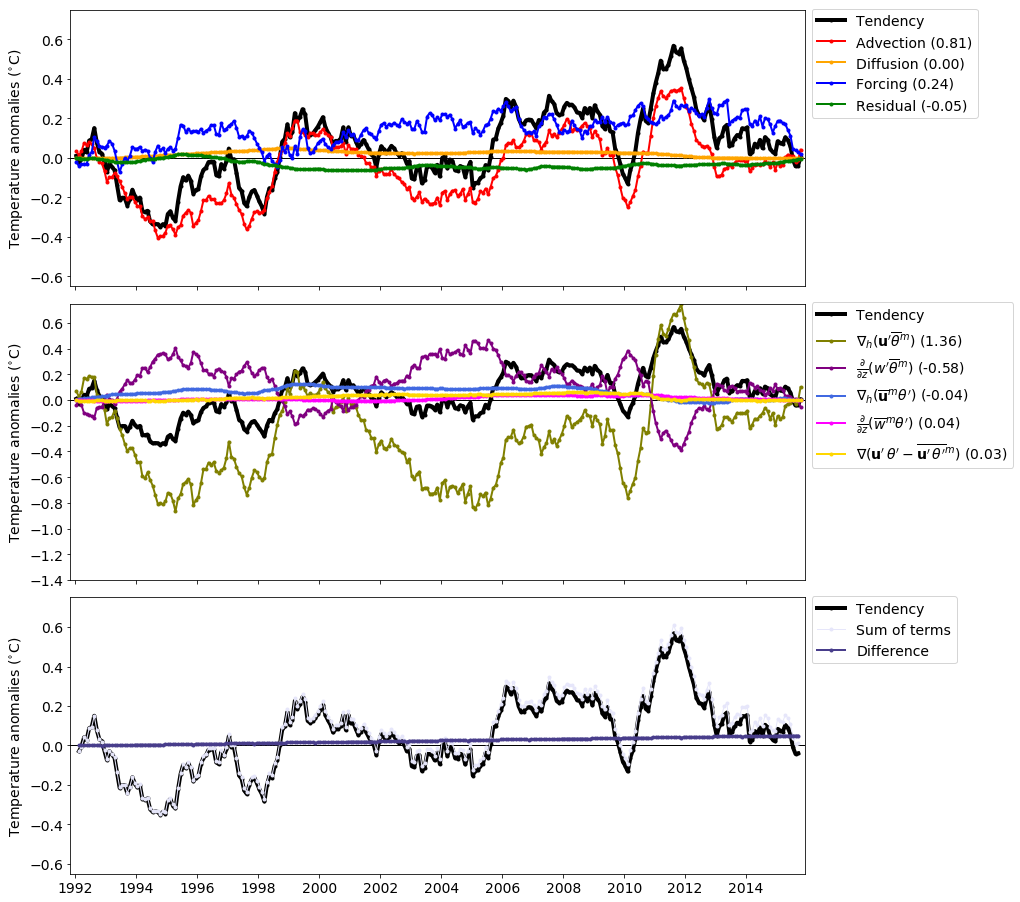

In [36]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(adv.time, adv, lw=2, color='red', marker='.',label=varstrngs[10] + ' (%.2f)' % corr[9])
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',label=varstrngs[11] + ' (%.2f)' % corr[4])
plt.plot(results[6].time, results[6], lw=2, color='blue', marker='.',label=varstrngs[12] + ' (%.2f)' % corr[5])
plt.plot(results[8].time, results[8], lw=2, color='green', marker='.',label=varstrngs[8] + ' (%.2f)' % corr[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-0.65,0.75])
plt.yticks(np.arange(-0.6,0.8,0.2),fontsize=14)
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(results[1].time, results[1], lw=2, color='olive',marker='.',label=varstrngs[1] + ' (%.2f)' % corr[0])
plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',label=varstrngs[2] + ' (%.2f)' % corr[1])
plt.plot(results[3].time, results[3], lw=2, color='royalblue', marker='.',label=varstrngs[3] + ' (%.2f)' % corr[2])
plt.plot(results[4].time, results[4], lw=2, color='magenta', marker='.',label=varstrngs[4] + ' (%.2f)' % corr[3])
plt.plot(results[7].time, results[7], lw=2, color='gold', marker='.',label=varstrngs[7] + ' (%.2f)' % corr[6])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-1.4,0.75])
plt.yticks(np.arange(-1.4,0.8,0.2),fontsize=14)
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time[1:-1], results[0][1:-1], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(total.time[1:-1], total[1:-1], lw=1, color='lavender', marker='.',label='Sum of terms')
plt.plot(results[0].time[1:-1], total[1:-1]-results[0][1:-1], lw=2, 
         color='darkslateblue', marker='.',label='Difference')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-0.65,0.75])
plt.yticks(np.arange(-0.6,0.8,0.2),fontsize=14)
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))
fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

plt.savefig('/rigel/home/jt2796/figure.png')
plt.savefig('/rigel/home/jt2796/figure.pdf')
plt.show()

### Trend

In [37]:
t = ds_int.time.astype(int)/1e9/3600/24/365.25
slope = pd.Series({term: np.polyfit(t,df[term],1)[0] for term in df})
itcpt = pd.Series({term: np.polyfit(t,df[term],1)[1] for term in df})

In [38]:
slope

tnd                 0.015865
hadv_Uanom_Tclim    0.016574
vadv_Uanom_Tclim   -0.004305
hadv_Uclim_Tanom   -0.002484
vadv_Uclim_Tanom    0.001217
dif                -0.000431
frc                 0.007863
adv_Uanom_Tanom     0.000782
res                -0.001162
total               0.018055
adv                 0.011784
dtype: float64

In [39]:
slope[1:9].sum()

0.018054994129330263

In [46]:
slope/slope.tnd

tnd                 1.000000
hadv_Uanom_Tclim    1.044689
vadv_Uanom_Tclim   -0.271354
hadv_Uclim_Tanom   -0.156568
vadv_Uclim_Tanom    0.076685
dif                -0.027144
frc                 0.495625
adv_Uanom_Tanom     0.049298
res                -0.073219
total               1.138011
adv                 0.742750
dtype: float64

In [47]:
trend_frc = slope/slope.total

In [48]:
trend_frc

tnd                 0.878726
hadv_Uanom_Tclim    0.917995
vadv_Uanom_Tclim   -0.238446
hadv_Uclim_Tanom   -0.137580
vadv_Uclim_Tanom    0.067385
dif                -0.023852
frc                 0.435518
adv_Uanom_Tanom     0.043319
res                -0.064339
total               1.000000
adv                 0.652673
dtype: float64

In [49]:
trend_frc[1:9].sum()

0.9999999999999998

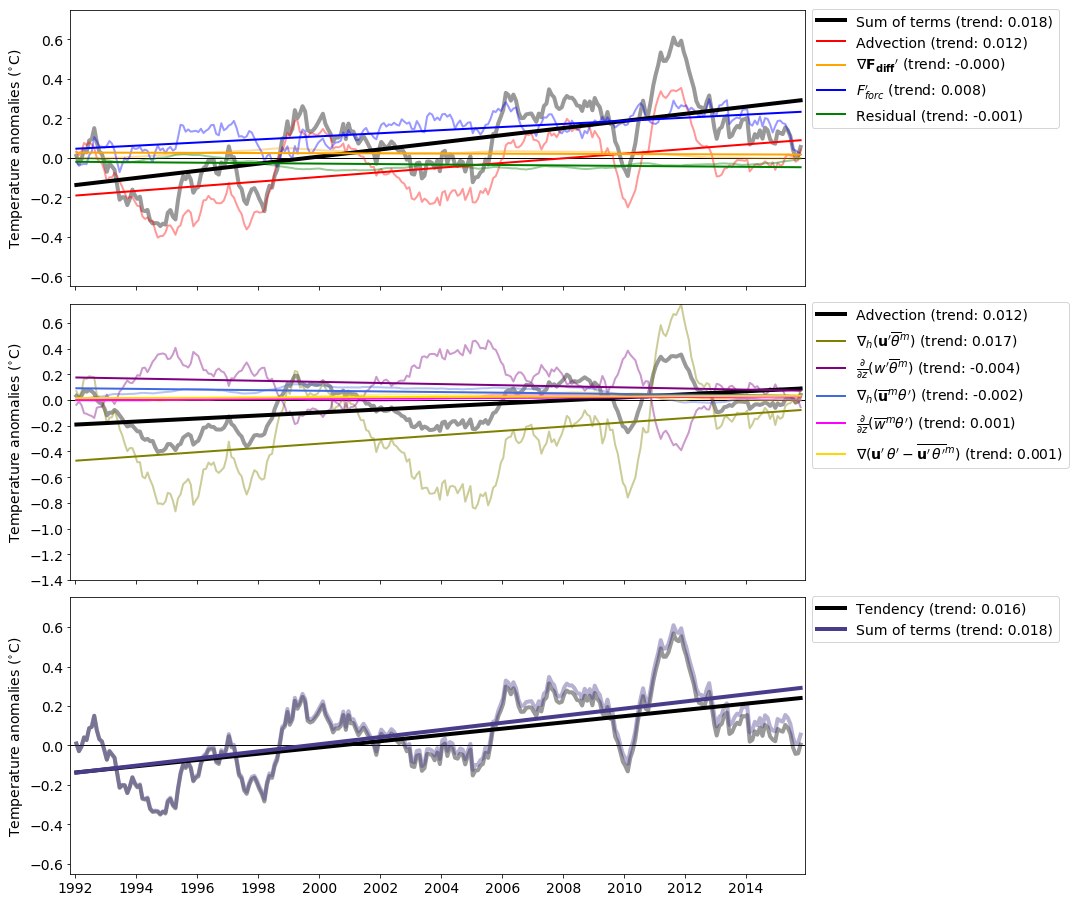

In [45]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
#plt.plot(results[0].time,results[0],lw=4,c='black',alpha=0.4,label='_nolegend_')
plt.plot(total.time, total,lw=4,c='black',alpha=0.4,label='_nolegend_')
plt.plot(adv.time,adv,lw=2,c='red',alpha=0.4,label='_nolegend_')
plt.plot(results[5].time,results[5],lw=2,c='orange',alpha=0.4,label='_nolegend_')
plt.plot(results[6].time,results[6],lw=2,c='blue',alpha=0.4,label='_nolegend_')
plt.plot(results[8].time,results[8],lw=2,c='green',alpha=0.4,label='_nolegend_')
plt.plot(total.time,slope[9]*t+itcpt[9],c='black',lw=4,linestyle='-',
         label='Sum of terms'+' (trend: %.3f)' % slope[9])
plt.plot(adv.time,slope[10]*t+itcpt[10],c='red',lw=2,linestyle='-',
         label=varstrngs[10]+' (trend: %.3f)' % slope[10])
plt.plot(results[5].time,slope[5]*t+itcpt[5],c='orange',lw=2,linestyle='-',
         label=varstrngs[5]+' (trend: %.3f)' % slope[5])
plt.plot(results[6].time,slope[6]*t+itcpt[6],c='blue',lw=2,linestyle='-',
         label=varstrngs[6]+' (trend: %.3f)' % slope[6])
plt.plot(results[8].time,slope[8]*t+itcpt[8],c='green',lw=2,linestyle='-',
         label=varstrngs[8]+' (trend: %.3f)' % slope[8])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-0.65,0.75])
plt.yticks(np.arange(-0.6,0.8,0.2),fontsize=14)
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

plt.plot(adv.time,adv,lw=4,c='black',alpha=0.4,label='_nolegend_')
plt.plot(results[1].time,results[1],lw=2,c='olive',alpha=0.4,label='_nolegend_')
plt.plot(results[2].time,results[2],lw=2,c='purple',alpha=0.4,label='_nolegend_')
plt.plot(results[3].time,results[3],lw=2,c='royalblue',alpha=0.4,label='_nolegend_')
plt.plot(results[4].time,results[4],lw=2,c='magenta',alpha=0.4,label='_nolegend_')
plt.plot(results[7].time,results[7],lw=2,c='gold',alpha=0.4,label='_nolegend_')
plt.plot(adv.time,slope[10]*t+itcpt[10],c='black',lw=4,linestyle='-',
         label=varstrngs[10]+' (trend: %.3f)' % slope[10])
plt.plot(results[1].time,slope[1]*t+itcpt[1],c='olive',lw=2,linestyle='-',
         label=varstrngs[1]+' (trend: %.3f)' % slope[1])
plt.plot(results[2].time,slope[2]*t+itcpt[2],c='purple',lw=2,linestyle='-',
         label=varstrngs[2]+' (trend: %.3f)' % slope[2])
plt.plot(results[3].time,slope[3]*t+itcpt[3],c='royalblue',lw=2,linestyle='-',
         label=varstrngs[3]+' (trend: %.3f)' % slope[3])
plt.plot(results[4].time,slope[4]*t+itcpt[4],c='magenta',lw=2,linestyle='-',
         label=varstrngs[4]+' (trend: %.3f)' % slope[4])
plt.plot(results[7].time,slope[7]*t+itcpt[7],c='gold',lw=2,linestyle='-',
         label=varstrngs[7]+' (trend: %.3f)' % slope[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-1.4,0.75])
plt.yticks(np.arange(-1.4,0.8,0.2),fontsize=14)
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time,results[0],lw=4,c='black',alpha=0.4,label='_nolegend_')
plt.plot(total.time, total,lw=4,c='darkslateblue',alpha=0.4,label='_nolegend_')
plt.plot(results[0].time,slope[0]*t+itcpt[0],c='black',lw=4,linestyle='-',
         label=varstrngs[0]+' (trend: %.3f)' % slope[0])
plt.plot(total.time,slope[9]*t+itcpt[9],c='darkslateblue',lw=4,linestyle='-',
         label='Sum of terms'+' (trend: %.3f)' % slope[9])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-0.65,0.75])
plt.yticks(np.arange(-0.6,0.8,0.2),fontsize=14)
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))
fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

plt.savefig('/rigel/home/jt2796/figure.png')
plt.savefig('/rigel/home/jt2796/figure.pdf')
plt.show()

### Correlation: Advection versus Forcing (Tendency vs Integrated)

In [25]:
import seaborn as sns

In [50]:
df.head()

,tnd,hadv_Uanom_Tclim,vadv_Uanom_Tclim,hadv_Uclim_Tanom,vadv_Uclim_Tanom,dif,frc,adv_Uanom_Tanom,res,total,adv
0,0.010208,0.069832,-0.037216,0.003107,0.000466,-0.000175,-0.021608,-0.003526,-0.000671,0.010208,0.032661
1,-0.028847,0.023015,-0.011299,0.007384,0.001114,-0.000423,-0.040143,-0.006031,-0.002465,-0.028847,0.014184
2,-0.005419,0.065937,-0.039110,0.011497,0.000568,-0.000617,-0.033601,-0.006503,-0.003590,-0.005419,0.032389
3,0.041053,0.170430,-0.102087,0.013161,-0.000150,-0.000912,-0.029999,-0.005645,-0.003745,0.041053,0.075709
4,0.027538,0.163765,-0.106946,0.014725,-0.001313,-0.001238,-0.031850,-0.005683,-0.003923,0.027538,0.064549


/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


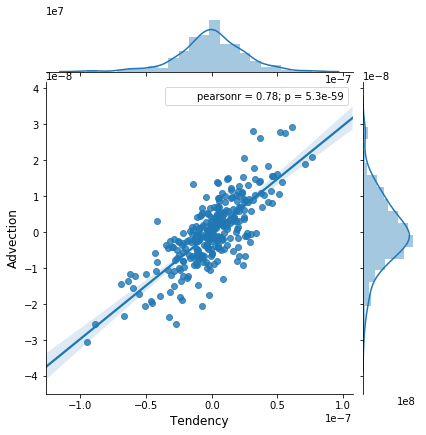

In [26]:
p=sns.jointplot(x="total", y="adv", data=df, kind="reg")
plt.xlabel(varstrngs[0],fontsize=12)
plt.ylabel(varstrngs[10],fontsize=12)
p.savefig('/rigel/home/jt2796/figure.png')

In [27]:
df['total'].cov(df['adv'])

1.8245910685333788e-16

In [28]:
df['total'].cov(df['frc'])

4.317473564177544e-16

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


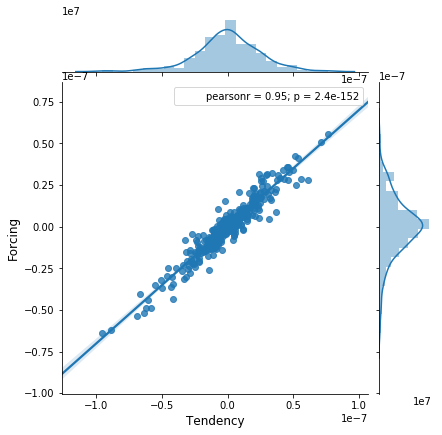

In [29]:
p=sns.jointplot(x="total", y="frc", data=df, kind="reg")
plt.xlabel(varstrngs[0],fontsize=12)
plt.ylabel(varstrngs[12],fontsize=12)
p.savefig('/rigel/home/jt2796/figure.png')

### Detrend

In [38]:
tnd = xr.DataArray(signal.detrend(results[0]),coords=[results[0].time],dims=['time'])
hadv_Uanom_Tclim = xr.DataArray(signal.detrend(results[1]),coords=[results[1].time],dims=['time'])
vadv_Uanom_Tclim = xr.DataArray(signal.detrend(results[2]),coords=[results[2].time],dims=['time'])
hadv_Uclim_Tanom = xr.DataArray(signal.detrend(results[3]),coords=[results[3].time],dims=['time'])
vadv_Uclim_Tanom = xr.DataArray(signal.detrend(results[4]),coords=[results[4].time],dims=['time'])
dif = xr.DataArray(signal.detrend(results[5]),coords=[results[5].time],dims=['time'])
frc = xr.DataArray(signal.detrend(results[6]),coords=[results[6].time],dims=['time'])
adv_Uanom_Tanom = xr.DataArray(signal.detrend(results[7]),coords=[results[7].time],dims=['time'])
res = xr.DataArray(signal.detrend(results[8]),coords=[results[8].time],dims=['time'])

In [39]:
results = dask.compute(tnd,hadv_Uanom_Tclim,vadv_Uanom_Tclim,
                       hadv_Uclim_Tanom,vadv_Uclim_Tanom,dif,frc,adv_Uanom_Tanom,res)

In [40]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8]
adv = results[1] + results[2] + results[3] + results[4] + results[7]

In [41]:
df = pd.DataFrame({'tnd':results[0],
                   'hadv_Uanom_Tclim':results[1],'vadv_Uanom_Tclim':results[2],
                   'hadv_Uclim_Tanom':results[3],'vadv_Uclim_Tanom':results[4],
                   'dif':results[5],'frc':results[6],
                   'adv_Uanom_Tanom':results[7],'res':results[8],
                   'total':total,'adv':adv})

In [42]:
corr = pd.Series({term: df['tnd'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.tnd,ddof=1)

In [43]:
corr[:8].sum()

1.0000457553730349

In [44]:
corr = pd.Series({term: df['total'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.total,ddof=1)

In [45]:
corr[:8].sum()

1.0

### Plot timeseries (integrated+detrended)

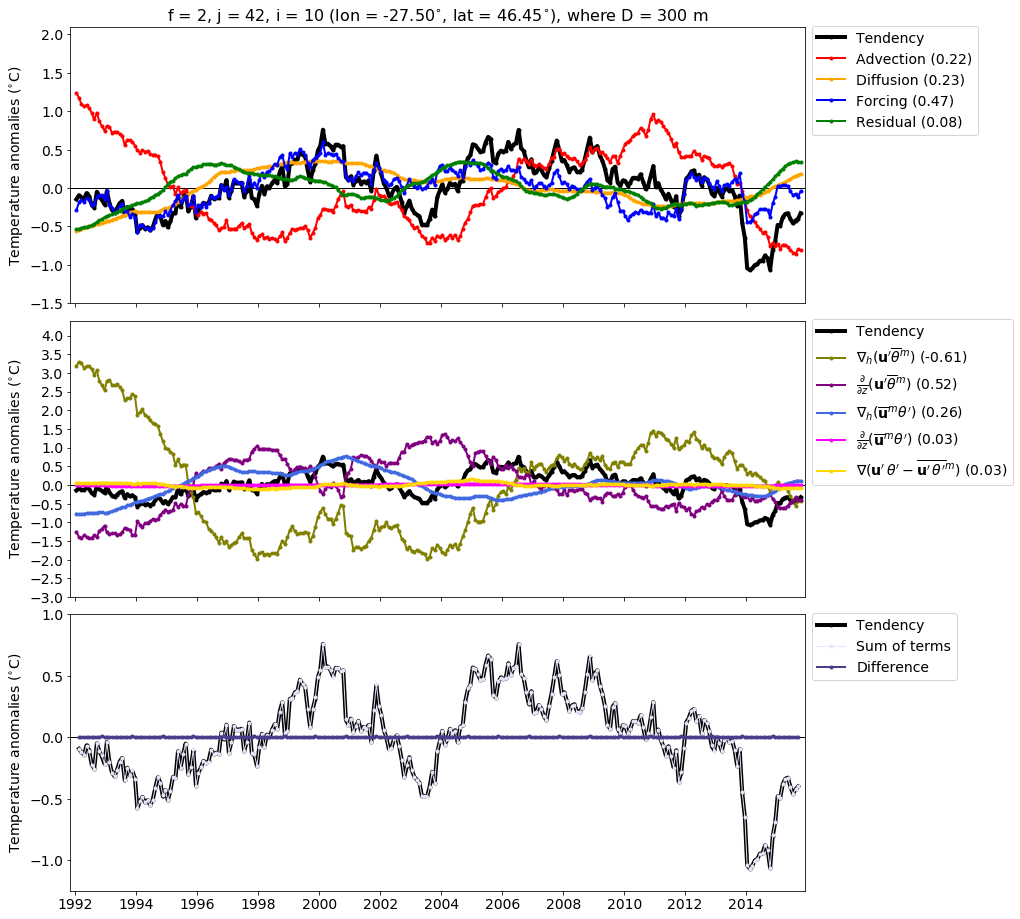

In [46]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.title(r'f = %s, j = %s, i = %s (lon = %.2f$^{\circ}$, lat = %.2f$^{\circ}$), where D = %s m' % (f,j,i,lon,lat,d), 
          fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(adv.time, adv, lw=2, color='red', marker='.',label=varstrngs[10] + ' (%.2f)' % corr[9])
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',label=varstrngs[11] + ' (%.2f)' % corr[4])
plt.plot(results[6].time, results[6], lw=2, color='blue', marker='.',label=varstrngs[12] + ' (%.2f)' % corr[5])
plt.plot(results[8].time, results[8], lw=2, color='green', marker='.',label=varstrngs[8] + ' (%.2f)' % corr[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-1.5,2.1])
plt.yticks(np.arange(-1.5,2.5,0.5),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-1.5,1.5,0.5))
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(results[1].time, results[1], lw=2, color='olive',marker='.',label=varstrngs[1] + ' (%.2f)' % corr[0])
plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',label=varstrngs[2] + ' (%.2f)' % corr[1])
plt.plot(results[3].time, results[3], lw=2, color='royalblue', marker='.',label=varstrngs[3] + ' (%.2f)' % corr[2])
plt.plot(results[4].time, results[4], lw=2, color='magenta', marker='.',label=varstrngs[4] + ' (%.2f)' % corr[3])
plt.plot(results[7].time, results[7], lw=2, color='gold', marker='.',label=varstrngs[7] + ' (%.2f)' % corr[6])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-3,4.4])
plt.yticks(np.arange(-3,4.5,0.5),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-2.5,2.5,0.5))
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time[1:-1], results[0][1:-1], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(total.time[1:-1], total[1:-1], lw=1, color='lavender', marker='.',label='Sum of terms')
plt.plot(results[0].time[1:-1], total[1:-1]-results[0][1:-1], lw=2, 
         color='darkslateblue', marker='.',label='Difference')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-1.25,1.0])
plt.yticks(np.arange(-1,1.5,0.5),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-1.5,1.5,0.5))
plt.ylabel(r'Temperature anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()